In [88]:
# ## Môi trường lập trình
# from google.colab import drive
# drive.mount("/content/drive", force_remount = True)
# #olderHoang = '/content/drive/My Drive/Semester 5/Machine Learning/Final Project_ML/Co-Working Space for Coding/Data'
# folderDuc = '/content/drive/MyDrive/Colab Notebooks/ML/Final Project_ML/Co-Working Space for Coding/Data'

In [89]:
# !pip install pyclustering

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from pyclustering.cluster.bang import bang, bang_visualizer, bang_animator
from sklearn.metrics import silhouette_score
from scipy.stats import skew
from scipy.stats import boxcox

%matplotlib inline

In [91]:
folder = "C:\\Users\\JOinme\\Downloads\\ML\\Data"


# Đọc dữ liệu

In [92]:
customer = pd.read_csv(folder + "/DimCustomer.csv")
geography = pd.read_csv(folder + "/DimGeography.csv")

Drop irrelevant columns

In [93]:
customer = customer.drop(['Unnamed: 0', 'FirstName', 'LastName', 'BirthDate', 'HouseOwnerFlag', 'NumberCarsOwned'], axis = 1)
geography = geography.drop(['CityName', 'StateProvinceName', 'RegionCountryName', 'GeographyType'], axis = 1)

In [94]:
customer.head()

,CustomerKey,GeographyKey,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation
0,1,680,M,M,90000.0,2.0,0.0,Bachelors,Professional
1,2,692,S,M,60000.0,3.0,3.0,Bachelors,Professional
2,3,493,M,M,60000.0,3.0,3.0,Bachelors,Professional
3,4,519,S,F,70000.0,0.0,0.0,Bachelors,Professional
4,5,706,S,F,80000.0,5.0,5.0,Bachelors,Professional


In [95]:
geography.head()

,GeographyKey,ContinentName
0,1,Asia
1,2,Europe
2,3,North America
3,269,Asia
4,270,Asia


Merge data

In [96]:
customer_geo = customer.merge(geography, on='GeographyKey')
customer_geo = customer_geo.drop(['CustomerKey', 'GeographyKey'], axis = 1)

In [97]:

customer_geo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18869 entries, 0 to 18868
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MaritalStatus         18869 non-null  object 
 1   Gender                18869 non-null  object 
 2   YearlyIncome          18869 non-null  float64
 3   TotalChildren         18869 non-null  float64
 4   NumberChildrenAtHome  18869 non-null  float64
 5   Education             18869 non-null  object 
 6   Occupation            18869 non-null  object 
 7   ContinentName         18869 non-null  object 
dtypes: float64(3), object(5)
memory usage: 1.2+ MB


# Data Cleaning

Missing values cleaning

In [98]:
customer_geo.isnull().any()

MaritalStatus           False
Gender                  False
YearlyIncome            False
TotalChildren           False
NumberChildrenAtHome    False
Education               False
Occupation              False
ContinentName           False
dtype: bool

In [99]:
customer_geo.isna().any()

MaritalStatus           False
Gender                  False
YearlyIncome            False
TotalChildren           False
NumberChildrenAtHome    False
Education               False
Occupation              False
ContinentName           False
dtype: bool

Outlier cleaning

In [100]:

numeric_cols = customer_geo.select_dtypes(include=np.number).columns
#Dropping outliers using z-score
def outliers_cleaning(data: pd.DataFrame, numeric_columns: list) -> pd.DataFrame:
    for column in numeric_columns:
        upper_limit = data[column].mean() + 3*data[column].std()
        lower_limit = data[column].mean() - 3*data[column].std()
        data = data[(data[column] >= lower_limit) & (data[column] <= upper_limit)]
    return data

customer_geo = outliers_cleaning(customer_geo, numeric_cols)

# Data Transformation

In [101]:

customer_geo.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,ContinentName
0,M,M,90000.0,2.0,0.0,Bachelors,Professional,Asia
1,S,M,60000.0,3.0,3.0,Bachelors,Professional,Asia
2,M,M,60000.0,3.0,3.0,Bachelors,Professional,Asia
3,S,F,70000.0,0.0,0.0,Bachelors,Professional,Asia
4,S,F,80000.0,5.0,5.0,Bachelors,Professional,Asia


Encode "MaritalStatus" column

In [102]:
mapping_maritalstatus = {'M': 1, 'S': 0} ##1: Married, 0: Single
customer_geo['MaritalStatus'] = [mapping_maritalstatus[marital] for marital in customer_geo['MaritalStatus']]

Encode "Gender" column

In [103]:
mapping_gender = {'F': 0, 'M': 1} ##0: Female, 1: Male
customer_geo['Gender'] = [mapping_gender[sex] for sex in customer_geo['Gender']]

Encode "Education" column

In [104]:
mapping_edu = {'Partial High School': 1, 'High School': 2, 'Partial College': 3, 'Bachelors': 4, 'Graduate Degree': 5}
customer_geo['Education'] = [mapping_edu[edu] for edu in customer_geo['Education']]

Encode "Operation" column

In [105]:
onehot_occupation = pd.get_dummies(customer_geo['Occupation'], dtype=np.int64)
customer_geo = pd.concat([customer_geo, onehot_occupation], axis = 1)
#Drop 'Occupation" column
customer_geo = customer_geo.drop('Occupation', axis = 1)

Encode "GeographyType" column

In [106]:
# customer_geo['GeographyType'].unique() ##Has only 1 value, not helping for segmentation, this column will be dropped


Encode "ContinentName" column

In [107]:
onehot_continent = pd.get_dummies(customer_geo['ContinentName'], dtype=np.int64)
customer_geo = pd.concat([customer_geo, onehot_continent], axis = 1)
#Drop 'ContinentName" column
customer_geo = customer_geo.drop('ContinentName', axis = 1)

Transform "YearlyIncome"

In [108]:
skew(customer_geo['YearlyIncome'])

np.float64(0.8220548594258209)

In [109]:
def transform_boxcox(data: pd.DataFrame, col: str) -> pd.Series:
    # Apply Box-Cox transformation
    transformed_data, _ = boxcox(data[col])
    
    # Apply MinMax scaling to bring values between 0 and 1
    scaler = MinMaxScaler()
    result = scaler.fit_transform(transformed_data.reshape(-1, 1)).flatten()
    
    return result.round(2)
  
customer_geo['YearlyIncome'] = transform_boxcox(customer_geo, 'YearlyIncome')

In [110]:
customer_geo.head()

,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Clerical,Management,Manual,Professional,Skilled Manual,Asia,Europe,North America
0,1,1,0.67,2.0,0.0,4,0,0,0,1,0,1,0,0
1,0,1,0.49,3.0,3.0,4,0,0,0,1,0,1,0,0
2,1,1,0.49,3.0,3.0,4,0,0,0,1,0,1,0,0
3,0,0,0.56,0.0,0.0,4,0,0,0,1,0,1,0,0
4,0,0,0.61,5.0,5.0,4,0,0,0,1,0,1,0,0


In [111]:
skew(customer_geo['YearlyIncome'])

np.float64(-0.037320917201577264)

# Data Reduction

Demensionality reduction

In [112]:
pca = PCA(n_components=2)
customer_geo_pca = pca.fit_transform(customer_geo)

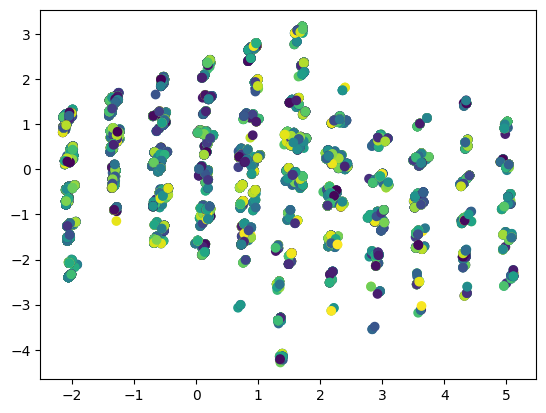

In [113]:
colors = np.random.rand(customer_geo_pca.shape[0])
plt.scatter(customer_geo_pca[:,0], customer_geo_pca[:,1], c = colors)